In [2]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [3]:
!pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 81.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 84.7 MB/s eta 0:00:00


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import AdamW, BertForSequenceClassification, get_linear_schedule_with_warmup

In [5]:
from tqdm import tqdm, trange
import pandas as pd
import io
import numpy as np
import matplotlib.pyplot as plt

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

In [7]:
df = pd.read_csv("in_domain_train.tsv", delimiter = '\t', header = None,
                 names = ['sentence_source','label','lable_notes','sentence']
                 )
df.shape

(8551, 4)

In [8]:
df.sample(10)

,sentence_source,label,lable_notes,sentence
963,bc01,1,NaN,john tries not to meet mary .
7726,ad03,1,NaN,what julie became was fond of lloyd .
41,gj04,0,*,they caused him to become president by making ...
4159,ks08,0,*,fifteen years represent a long period of his l...
7635,sks13,1,NaN,bill is sick .
5448,b_73,1,NaN,he 's a reliable enough man .
6201,c_13,1,NaN,shelly loves who ?
6765,m_02,1,NaN,never had sir thomas been so offended .
4840,ks08,1,NaN,who will john ask for information about summer...
8178,ad03,1,NaN,he will can go


In [9]:
sentences = df.sentence.values

#Adding CLS and SEP tokens at the beginning and end of each sentence for BERT
sentences = ["[CLS]" + sentence + "[SEP]" for sentence in sentences]
labels = df.label.values

In [10]:
sentences

["[CLS]our friends wo n't buy this analysis , let alone the next one we propose .[SEP]",
 "[CLS]one more pseudo generalization and i 'm giving up .[SEP]",
 "[CLS]one more pseudo generalization or i 'm giving up .[SEP]",
 '[CLS]the more we study verbs , the crazier they get .[SEP]',
 '[CLS]day by day the facts are getting murkier .[SEP]',
 "[CLS]i 'll fix you a drink .[SEP]",
 '[CLS]fred watered the plants flat .[SEP]',
 '[CLS]bill coughed his way out of the restaurant .[SEP]',
 "[CLS]we 're dancing the night away .[SEP]",
 '[CLS]herman hammered the metal flat .[SEP]',
 '[CLS]the critics laughed the play off the stage .[SEP]',
 '[CLS]the pond froze solid .[SEP]',
 '[CLS]bill rolled out of the room .[SEP]',
 '[CLS]the gardener watered the flowers flat .[SEP]',
 '[CLS]the gardener watered the flowers .[SEP]',
 '[CLS]bill broke the bathtub into pieces .[SEP]',
 '[CLS]bill broke the bathtub .[SEP]',
 '[CLS]they drank the pub dry .[SEP]',
 '[CLS]they drank the pub .[SEP]',
 '[CLS]the profess

In [11]:
#Activating the BERT tokenizer

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case = True)
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print("Tokenize the first sentence: ")
print(tokenized_texts[0])

Tokenize the first sentence: 
['[CLS]', 'our', 'friends', 'wo', 'n', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.', '[SEP]']


In [13]:
#Processing the data

In [14]:
#in the original paper, the authors used a length of 512
MAX_LEN = 128

#use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

#Pad our input tokens
input_ids = tf.keras.utils.pad_sequences(
    input_ids,
    maxlen=None,
    dtype='long',
    padding='post',
    truncating='post',
)

In [15]:
input_ids

array([[ 101, 2256, 2814, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       [ 101, 2028, 2062, ...,    0,    0,    0],
       ...,
       [ 101, 2009, 2003, ...,    0,    0,    0],
       [ 101, 1045, 2018, ...,    0,    0,    0],
       [ 101, 2054, 2035, ...,    0,    0,    0]])

In [16]:
#CREATING ATTENTION MASKS
#we padded the sequences in the previous cell, but we want to prevent
#the model from performing attenetion on those padded tokens.
attention_masks = []

#create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask)

In [17]:
# attention_masks

In [18]:
#SPLITTING THE DATA INTO TRAINING AND VALIDAITON SETS

train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2018, test_size = 0.1
)
train_masks, validation_masks, _,_ = train_test_split(
    attention_masks, input_ids, random_state=2018, test_size = 0.1
)

In [19]:
#CONVERTING ALL THE DATA INTO TORCH TENSORS

#torch tensors are the required datatype for our model

train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [20]:
#SELECTING A BATCH SIZE AND CREATING AN ITERATOR
# Select a batch size for training. For fine-tuning BERT on a specific
# task, the authors recommend a batch size of 16 or 32
batch_size = 32

#create an iterator of our data with torch Dataloader, helps save on memory during training because, unlike a for loop, 
#with an iterator the entire dataset doesnot need to be loaded into memory

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = RandomSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler = validation_sampler, batch_size = batch_size)

In [21]:
#BERT MODEL CONFIGURATION

try:
  import transformers
except:
  print("Installing Transformers")
  !pip -qq install transformers

from transformers import BertModel, BertConfig
configuration = BertConfig()

model = BertModel(configuration)

configuration = model.config
print(configuration)

BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.26.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



attention_probs_dropout_prob: 0.1 applies a 0.1 dropout ratio to the
•hidden_act: "gelu" is a non-linear activation function in the encoder. It is a
•hidden_dropout_prob: 0.1 is the dropout probability applied to the fully
connected layers. Full connections can be found in the embeddings, encoder,
and pooler layers. The pooler is there to convert the sequence tensor for
classification tasks, which require a fixed dimension to represent the
sequence. The pooler will thus convert the sequence tensor to (batch size,
hidden size), which are fixed parameters.
•hidden_size: 768 is the dimension of the encoded layers and also the pooler
•initializer_range: 0.02 is the standard deviation value when initializing the
•intermediate_size: 3072 is the dimension of the feed-forward layer of the
•layer_norm_eps: 1e-12 is the epsilon value for layer normalization layers.
•max_position_embeddings: 512 is the maximum length the model uses.
•model_type: "bert" is the name of the model.
•num_attention_heads: 12 is the number of heads.
•num_hidden_layers: 12 is the number of layers.
•pad_token_id: 0 is the ID of the padding token to avoid training padding
attention probabilities.
Gaussian Error Linear Units activation function. The input is weighted by its
magnitude, which makes it non-linear.
layer.
weight matrices.
encoder.
tokens.
•type_vocab_size: 2 is the size of the token_type_ids, which identify the
sequences. For example, "the dog[SEP] The cat.[SEP]" can be represented
with 6 token IDs: [0,0,0, 1,1,1].
•vocab_size: 30522 is the number of different tokens used by the model to
represent the input_ids.
With these parameters in mind, we can load the pretrained model.





In [22]:
#LOADING THE HUGGING FACE BERT uncased base model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [23]:
#OPTIMIZED GROUP PARAMETERS

# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbe
#d2d008813037968a9e58/examples/run_glue.py#L102

# # Don't apply weight decay to any parameters whose names include these
#tokens.
# (Here, the BERT doesn't have 'gamma' or 'beta' parameters, only
#'bias' terms)

param_optimizer = list(model.named_parameters())
no_decay = ['bias','LayerNorm.weight']
# Separate the 'weight' parameters from the 'bias' parameters.
# - For the 'weight' parameters, this specifies a 'weight_decay_rate'
#of 0.01.
# - For the 'bias' parameters, the 'weight_decay_rate' is 0.0.

optimizer_grouped_parameters = [
    # filter for all parameters which dont include 'bias' , 'gamma', 'beta'
    {'params': [p for n,p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    {'params': [p for n,p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

#optimizer_grouped_parameters only includes the parameter values, not the names

In [28]:
#HYPERPARAMETERS for the training loop
t = []
train_loss_set = []

epochs = 4

optimizer = AdamW(optimizer_grouped_parameters,
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [29]:
#Creating the accuracy measurement function
#function to calculate the accuracy of our predictions vs labels

def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)

In [30]:
#@title The Training Loop
t = [] 

# Store our loss and accuracy for plotting
train_loss_set = []

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    # Forward pass
    outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
    loss = outputs['loss']
    train_loss_set.append(loss.item())    
    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    optimizer.step()

    # Update the learning rate.
    scheduler.step()
    
    
    # Update tracking variables
    tr_loss += loss.item()
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss, eval_accuracy = 0, 0
  nb_eval_steps, nb_eval_examples = 0, 0

  # Evaluate data for one epoch
  for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      logits = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
    
    # Move logits and labels to CPU
    logits = logits['logits'].detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

  print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.4860659232401749


Epoch:  25%|██▌       | 1/4 [01:06<03:18, 66.03s/it]

Validation Accuracy: 0.8090277777777778
Train loss: 0.28674977006877606


Epoch:  50%|█████     | 2/4 [02:10<02:10, 65.06s/it]

Validation Accuracy: 0.8275462962962963
Train loss: 0.1693373371874025


Epoch:  75%|███████▌  | 3/4 [03:14<01:04, 64.63s/it]

Validation Accuracy: 0.8298611111111112
Train loss: 0.10885927591210084


Epoch: 100%|██████████| 4/4 [04:18<00:00, 64.61s/it]

Validation Accuracy: 0.8167438271604938


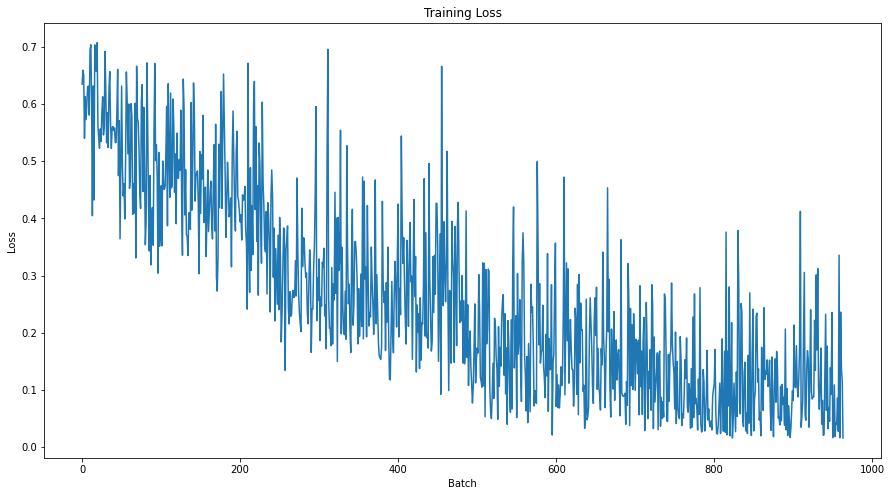

In [31]:
#@title training Evaluation
plt.figure(figsize=(15,8))
plt.title("Training Loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

In [35]:
#@title Predicting and Evaluating Using the Hold-out Dataset 
df = pd.read_csv("out_of_domain_dev.tsv", delimiter='\t', header=None, names=['sentence_source', 'label', 'label_notes', 'sentence'])

# Create sentence and label lists
sentences = df.sentence.values

# We need to add special tokens at the beginning and end of each sentence for BERT to work properly
sentences = ["[CLS] " + sentence + " [SEP]" for sentence in sentences]
labels = df.label.values

tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]


MAX_LEN = 128

# Use the BERT tokenizer to convert the tokens to their index numbers in the BERT vocabulary
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
# Pad our input tokens
input_ids = tf.keras.utils.pad_sequences(
                input_ids,
                maxlen=None,
                dtype='long',
                padding='post',
                truncating='post',
            )

# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

prediction_inputs = torch.tensor(input_ids)
prediction_masks = torch.tensor(attention_masks)
prediction_labels = torch.tensor(labels)
  
batch_size = 32  


prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)
     

In [38]:
#prediction on test set

model.eval()
predictions, true_labels = [],[]

for batch in prediction_dataloader:
  batch = tuple(t.to(device) for t in batch)

  #unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  with torch.no_grad():
    logits = model(b_input_ids, token_type_ids = None, attention_mask=b_input_mask)
  
  logits = logits['logits'].detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

In [39]:
#import and evaluate each test batch using Matthew's correlation coefficient
from sklearn.metrics import matthews_corrcoef
matthews_set = []

for i in range(len(true_labels)):
  matthews = matthews_corrcoef(true_labels[i],
                               np.argmax(predictions[i],axis=1).flatten())
  matthews_set.append(matthews)

In [40]:
matthews_set

[-0.14856415213808927,
 -0.1044465935734187,
 0.4732058754737091,
 0.30508307783296046,
 0.4133804997216296,
 0.6147253896340708,
 0.4472135954999579,
 0.47519096331149147,
 0.8320502943378436,
 0.6952687917708212,
 0.8459051693633014,
 0.647150228929434,
 0.8749672939989046,
 0.7141684885491869,
 0.1794871794871795,
 0.5056936741642399,
 0.0]

In [41]:
flat_predictions = [item for sublist in predictions for item in sublist]
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = [item for sublist in true_labels for item in sublist]
matthews_corrcoef(flat_true_labels, flat_predictions)

0.5141926298737706